# SDDP:  advanced tutorial

Consider two dams in the same valley. These two dams are connected together, as we suppose that the water turbined by the first dam is an input of the second dam. The goal of this notebook is to show how to use the Stochastic Dual Dynamic Programming (SDDP) algorithm to find how to manage optimally these two dams. 

## Mathematical formulation:

We use a hydropower management testcase. 

We consider a valley with $N_{dams}$, all in the same river. 

### Dynamic

Assume that we have a water inflow $W_t^i$ which arrives in the $i$-th dam between $t$ and $t+1$. This dam turbines a quantity $U_t^i$ of water, and spill a quantity $S_t^i$ (to achieve relatively complete recourse). 

Thus, dynamic of first dam becomes: 

$$ X_{t+1}^1 = X_{t}^1 + W^t - U_t^1 - S_t^1 $$

The turbined flow arrives in the second dam, which turbines a quantity $U_t^2$ and spills a quantity $S_t^2$, and so on for $i \in [[2, N_{dams}|]$. So for all $i \geq 1$, we have the dynamic:

$$ X_{t+1}^i = X_{t}^i + U_t^{i-1} + S_t^{i-1} - U_t^i - S_t^i + W_t^i$$

Thus, we could define the state:
$$ X_t = (X_t^i)_{i=1}^{N_{dams}}$$

and the control:
$$U_t = (U_t^i, S_t^i)_{i=1}^{N_{dams}} $$

### Costs

The two turbines produce a quantity of electricity proportionnal to the flow turbined, and this electricity is sold into the market at a price $c_t$. So we gain at each timestep:

$$ C_t(X_t, U_t) = c_t  \sum_{i=1}^{N_{dams}} U_t^i $$

Here, we suppose that costs are negative, as we sell electricity onto the network. 

We want to maximize our expected gains, so we minimize the following quantity:

$$ J = \mathbb{E} \left[ \sum_{i=1}^{T_f} C_t(X_t, U_t) \right]$$ 


--- 

## Problem formulation: 

First, we need to import some modules: 

In [1]:
using StochDynamicProgramming, JuMP, Gurobi #,Clp, Gurobi

INFO: Recompiling stale cache file /home/fpacaud/.julia/lib/v0.6/StochDynamicProgramming.ji for module StochDynamicProgramming.


In [2]:
using PyPlot

In [3]:
# and we set a random seed for replicatibility:
srand(2713);

### Implementation of stochastic problem: 

We set the number of dams in our valley: 

In [4]:
begin const
    N_DAMS = 5
    N_STAGES = 12
    N_ALEAS = 10
end


10

### Definition of bounds upon states and controls

In [5]:
# Constants:
const VOLUME_MAX = 80
const VOLUME_MIN = 0

const CONTROL_MAX = 40
const CONTROL_MIN = 0

# Define initial status of stocks:
const X0 = [40 for i in 1:N_DAMS];

### Definition of noise's laws: 

In [6]:

noiselaws = Vector{NoiseLaw}(N_STAGES-1)
# uniform probabilities:
proba = 1/N_ALEAS*ones(N_ALEAS)

for t=1:N_STAGES-1
    support = rand(0:9, N_DAMS, N_ALEAS)
    noiselaws[t] = NoiseLaw(support, proba)
end




### Definition of dynamic: 

In [7]:
# Dynamic of stocks:
const A = eye(N_DAMS)
# The problem has the following structure:
# dam1 -> dam2 -> dam3 -> dam4 -> dam5
# We need to define the corresponding dynamic:
const B =  [-1  0.  0.  0.  0.  -1  0.  0.  0.  0.;
            1.  -1  0.  0.  0.  1.  -1  0.  0.  0.;
            0.  1.  -1  0.  0.  0.  1.  -1  0.  0.;
            0.  0.  1.  -1  0.  0.  0.  1.  -1  0.;
            0.  0.  0.  1.  -1  0.  0.  0.  1.  -1]
# Define dynamic of the dam:
function dynamic(t, x, u, w)
    return A*x + B*u + w
end

dynamic (generic function with 1 method)

### Definition of costs: 

In [8]:
# Cost are negative as we sell the electricity produced by
# dams (and we want to minimize our problem)
const COST = -66*2.7*(1 + .5*(rand(N_STAGES) - .5))

# Define cost corresponding to each timestep:
function cost_t(t, x, u, w)
    return COST[t] * sum(u[1:N_DAMS])
end

cost_t (generic function with 1 method)

### Definition of final cost: 

In [9]:
function final_cost_dams(model, m)
    alpha = m[:alpha]
    w = m[:w]
    x = m[:x]
    u = m[:u]
    xf = m[:xf]
    @JuMP.variable(m, z1[1:N_DAMS] >= 0)
    @JuMP.constraint(m, alpha == 0.)
    @JuMP.constraint(m, z1 .>= 40. - xf)
    @JuMP.objective(m, Min, model.costFunctions(model.stageNumber-1, x, u, w) +
                            500*sum(z1'*z1))
end


final_cost_dams (generic function with 1 method)

### Definition of SPModel:

In [10]:
x_bounds = [(VOLUME_MIN, VOLUME_MAX) for i in 1:N_DAMS]
u_bounds = vcat([(CONTROL_MIN, CONTROL_MAX) for i in 1:N_DAMS], [(0., 200) for i in 1:N_DAMS]);

In [11]:
model = LinearSPModel(N_STAGES, # number of states in our problem
                    u_bounds, # bounds upon control
                    X0, # initial position 
                    cost_t, # instantaneous cost
                    dynamic, # dynamic 
                    noiselaws, # noises modelling 
                    Vfinal=final_cost_dams # Final cost
                    );

In [12]:
# Add bounds for stocks:
set_state_bounds(model, x_bounds);

## Parametrization of SDDP: 

In [13]:
#solver = CPLEX.CplexSolver(CPX_PARAM_SIMDISPLAY=0, CPX_PARAM_BARDISPLAY=0);
solver = GurobiSolver(OutputFlag=0)

Gurobi.GurobiSolver(nothing, Any[(:OutputFlag, 0)])

In [14]:
params = SDDPparameters(solver,
                        passnumber=10,
                        max_iterations=50);


## Solving 

In [49]:
srand(111)
sddp = @time solve_SDDP(model, params, 2, 10);

SDDP Interface initialized
Initialize cuts
Starting SDDP iterations
Pass n° 10	Lower-bound: -1.4215e+05	Time: 0.19s
Pass n° 20	Lower-bound: -1.4165e+05	Time: 0.26s
Pass n° 30	Lower-bound: -1.4160e+05	Time: 0.33s
Pass n° 40	Lower-bound: -1.4157e+05	Time: 0.39s
Pass n° 50	Lower-bound: -1.4155e+05	Time: 0.51s
 15.743521 seconds (8.61 M allocations: 1.723 GiB, 2.56% gc time)


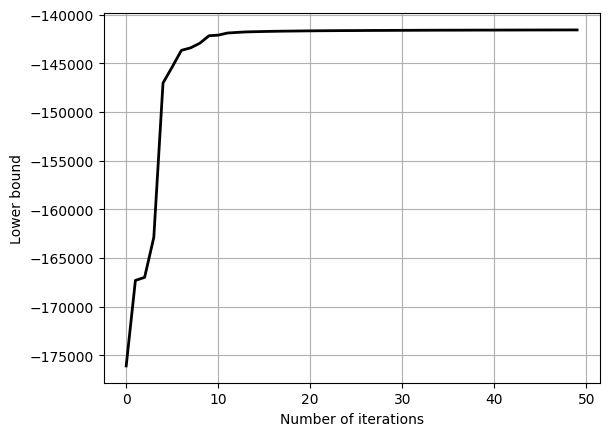

In [16]:
# We plot evolution of lower-bound: 
plot(sddp.stats.lower_bounds, lw=2, c="k")
grid()

xlabel("Number of iterations")
ylabel("Lower bound");

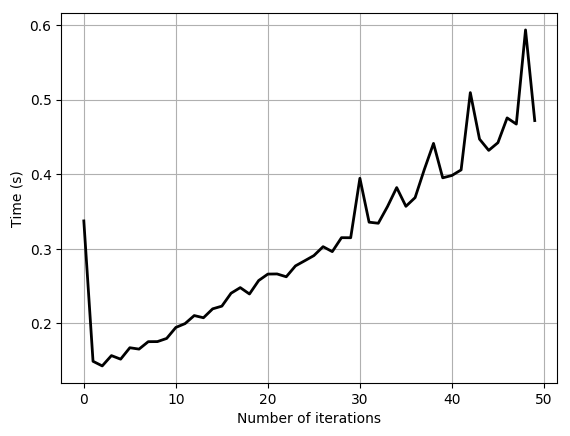

In [17]:
# and evolution of execution time: 
plot(sddp.stats.exectime, lw=2, c="k")
grid()

xlabel("Number of iterations")
ylabel("Time (s)");

## Quadratic regularization 

In [18]:
params2 = SDDPparameters(solver,
                        passnumber=10,                        
                        max_iterations=50);

In [32]:
srand(111)
sddp_r = @time solve_SDDP(model, params2, 2, 10, 
                        regularization=SDDPRegularization(1., .95));

SDDP Interface initialized
Initialize cuts
Starting SDDP iterations
Pass n° 10	Lower-bound: -1.4184e+05	Time: 0.32s
Pass n° 20	Lower-bound: -1.4162e+05	Time: 0.47s
Pass n° 30	Lower-bound: -1.4158e+05	Time: 0.63s
Pass n° 40	Lower-bound: -1.4156e+05	Time: 0.79s
Pass n° 50	Lower-bound: -1.4155e+05	Time: 0.97s
 28.415582 seconds (13.87 M allocations: 2.098 GiB, 2.38% gc time)


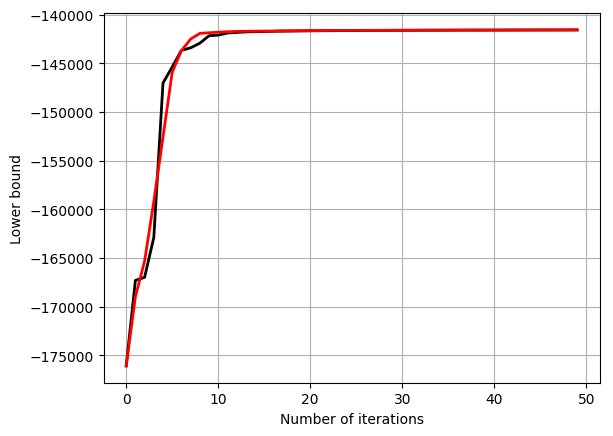

In [33]:
plot(sddp.stats.lower_bounds, lw=2, c="k")
plot(sddp_r.stats.lower_bounds, lw=2, c="r")
grid()

xlabel("Number of iterations")
ylabel("Lower bound");

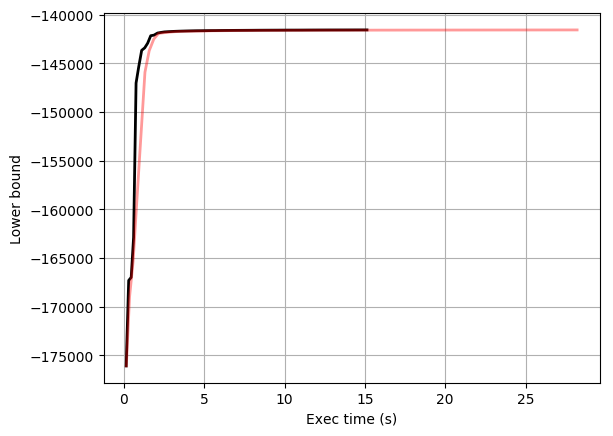

In [35]:
plot(cumsum(sddp.stats.exectime), sddp.stats.lower_bounds, lw=2, c="k")
plot(cumsum(sddp_r.stats.exectime), sddp_r.stats.lower_bounds, lw=2, c="r", alpha=.4)
grid()
xlabel("Exec time (s)")
ylabel("Lower bound");

## Cuts pruning

In [37]:
using CutPruners

In [44]:
params3 = SDDPparameters(solver,
                        passnumber=10,
                        max_iterations=50,
                        prune=true, # we want to prune cuts
                        reload=2   # and reload JuMP Model every 2 iterations
    );

In [58]:
sddp_cp = SDDPInterface(model, params3,
                     StochDynamicProgramming.IterLimit(params3.max_iterations),
                     CutPruners.DeMatosPruningAlgo(1000),
                     verbose_it=10)


SDDP Interface initialized
Pass n° 0

BoundsError: [91mBoundsError: attempt to access 0-element Array{Float64,1} at index [0][39m

In [59]:
srand(2713)
solve!(sddp_cp)

Initialize cuts
Starting SDDP iterations
Pass n° 10	Lower-bound: -1.4282e+05	Time: 0.22s
Pass n° 20	Lower-bound: -1.4165e+05	Time: 0.4s
Pass n° 30	Lower-bound: -1.4159e+05	Time: 0.52s
Pass n° 40	Lower-bound: -1.4157e+05	Time: 0.55s
Pass n° 50	Lower-bound: -1.4155e+05	Time: 0.64s


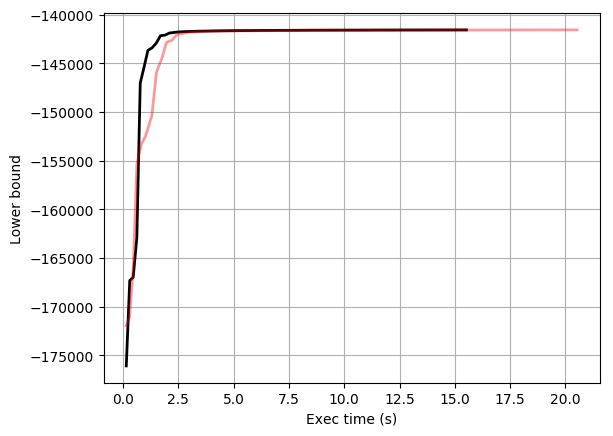

In [60]:
plot(cumsum(sddp.stats.exectime), sddp.stats.lower_bounds, lw=2, c="k")
plot(cumsum(sddp_cp.stats.exectime), sddp_cp.stats.lower_bounds, lw=2, c="r", alpha=.4)
grid()
xlabel("Exec time (s)")
ylabel("Lower bound");